In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-06-29 21:50:56.642253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the dataset
file_path = 'asrs_whole_cleaned_data.csv'
asrs_data = pd.read_csv(file_path, low_memory=False)

In [3]:
# Display the column names
print(asrs_data.columns)

Index(['Unnamed: 0', 'ACN', 'aircraft_1__ATC / Advisory',
       'aircraft_1__Aircraft Operator', 'aircraft_1__Make Model Name',
       'aircraft_1__Aircraft Zone', 'aircraft_1__Crew Size',
       'aircraft_1__Operating Under FAR Part', 'aircraft_1__Flight Plan',
       'aircraft_1__Mission',
       ...
       'place__Altitude.MSL.Single Value', 'place__Latitude / Longitude (UAS)',
       'report_1__Narrative', 'report_1__Callback', 'report_1__Synopsis',
       'report_2__Narrative', 'report_2__Callback', 'time__Date',
       'time__Local Time Of Day', 'unnamed:_125__Unnamed: 1'],
      dtype='object', length=127)


In [4]:
# Check for any missing values
print(asrs_data.isnull().sum())

Unnamed: 0                           0
ACN                                  0
aircraft_1__ATC / Advisory       19670
aircraft_1__Aircraft Operator     5297
aircraft_1__Make Model Name        172
                                 ...  
report_2__Narrative              56978
report_2__Callback               73449
time__Date                           0
time__Local Time Of Day           7104
unnamed:_125__Unnamed: 1         73606
Length: 127, dtype: int64


In [5]:
# Display the column names
# print(asrs_data['assessments__Primary Problem'])
asrs_data['assessments__Primary Problem'] = asrs_data['assessments__Primary Problem'].fillna('NONE')

In [6]:
# Drop rows with missing values in the relevant columns
data = asrs_data.dropna(subset=['report_1__Narrative', 'assessments__Primary Problem'])

In [7]:
# Limitation: Sample a subset of the data for faster training
data = asrs_data.sample(frac=0.01, random_state=42).copy()
data

,Unnamed: 0,ACN,aircraft_1__ATC / Advisory,aircraft_1__Aircraft Operator,aircraft_1__Make Model Name,aircraft_1__Aircraft Zone,aircraft_1__Crew Size,aircraft_1__Operating Under FAR Part,aircraft_1__Flight Plan,aircraft_1__Mission,...,place__Altitude.MSL.Single Value,place__Latitude / Longitude (UAS),report_1__Narrative,report_1__Callback,report_1__Synopsis,report_2__Narrative,report_2__Callback,time__Date,time__Local Time Of Day,unnamed:_125__Unnamed: 1
40938,40938,1489429,TRACON L30,Air Carrier,B737 Undifferentiated or Other Model,NaN,2.0,Part 121,IFR,Passenger,...,11000.0,NaN,The weather was clear and smooth and after dar...,NaN,B737 First Officer reported that a SID crossin...,NaN,NaN,201710,0001-0600,NaN
30369,30369,1310361,NaN,Air Carrier,B737-700,NaN,NaN,Part 121,NaN,NaN,...,NaN,NaN,Last night; [early evening]; I walked up the G...,NaN,An Aircraft Maintenance Technician reports abo...,NaN,NaN,201511,0001-0600,NaN
32504,32504,1342763,Center ZHU,Air Carrier,EMB ERJ 145 ER/LR,NaN,2.0,Part 121,IFR,Passenger,...,35000.0,NaN,A line of thunderstorms was approaching PNS fr...,NaN,An EMB-145 Captain reported losing reliable ai...,NaN,NaN,201603,1201-1800,NaN
652,652,874102,NaN,Air Carrier,Regional Jet 200 ER/LR (CRJ200),NaN,NaN,Part 121,NaN,Passenger,...,NaN,NaN,A CRJ-200 had an altitude select problem; it w...,Reporter stated all Operators of the CRJ-200's...,An Air Carrier Maintenance Manager reports on ...,NaN,NaN,201001,0601-1200,NaN
37280,37280,1424003,Tower HIO,Personal,Small Aircraft; High Wing; 1 Eng; Fixed Gear,NaN,1.0,Part 91,VFR,Personal,...,700.0,NaN,I was working Local Control. The airport was i...,NaN,HIO Tower Controller reported an airborne conf...,NaN,NaN,201702,1201-1800,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55508,55508,1745485,Tower ZZZ,Personal,Small Aircraft; Low Wing; 2 Eng; Retractable Gear,NaN,1.0,Part 91,NaN,Personal,...,NaN,NaN,I was picking up my aircraft from ZZZ airport ...,NaN,Pilot reported a taxiway incursion; citing dis...,NaN,NaN,202006,1201-1800,NaN
21885,21885,1167253,Center ZAU,Air Carrier,Regional Jet 700 ER/LR (CRJ700),NaN,2.0,Part 121,NaN,Passenger,...,24000.0,NaN,We received a clearance to descend to FL240 an...,NaN,CRJ-700 Captain reports being cleared to desce...,NaN,NaN,201404,1201-1800,NaN
15518,15518,1046796,NaN,Air Carrier,A319,NaN,2.0,Part 121,IFR,Passenger,...,NaN,NaN,We had no discrepancies during our flight. Upo...,NaN,A319 Captain becomes aware after landing that ...,NaN,NaN,201211,0601-1200,NaN
6724,6724,942444,Center ZMP,Air Carrier,DC-9 Undifferentiated or Other Model,NaN,2.0,Part 121,IFR,NaN,...,15000.0,NaN,I was working the departure sector off of MSP ...,NaN,ZMP Controller described a near separation los...,NaN,NaN,201104,1801-2400,NaN


In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    # text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Assuming 'data' is your DataFrame and 'report_1__Narrative' is the text column
data['cleaned_text'] = data['report_1__Narrative'].apply(preprocess_text)

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Label Encoding for the target variable
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['assessments__Primary Problem'])

In [13]:
# Tokenize the text
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

# Pad sequences to ensure uniform input length
max_len = 100
X = pad_sequences(sequences, maxlen=max_len)
y = data['label']

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
batch_size = 64
epochs = 5

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.2268 - loss: 0.4350 - val_accuracy: 0.3333 - val_loss: -1.2328
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.2614 - loss: -6.3213 - val_accuracy: 0.3333 - val_loss: -32.7857
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.2755 - loss: -34.2256 - val_accuracy: 0.3333 - val_loss: -48.3475
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.2830 - loss: -48.3257 - val_accuracy: 0.3333 - val_loss: -61.3855
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.2599 - loss: -62.3303 - val_accuracy: 0.3333 - val_loss: -71.4628


6/6 - 0s - 49ms/step - accuracy: 0.2391 - loss: -7.7360e+01
Test Accuracy: 0.24


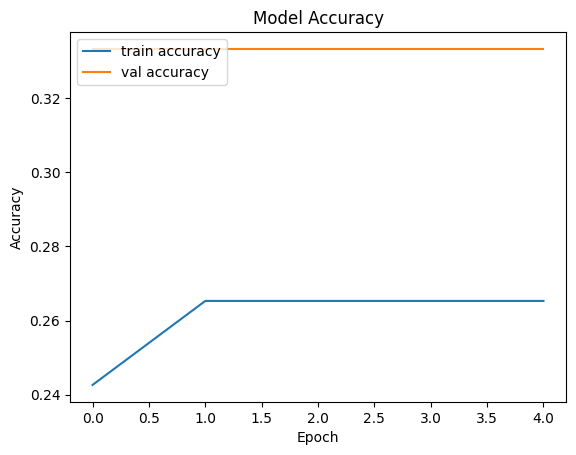

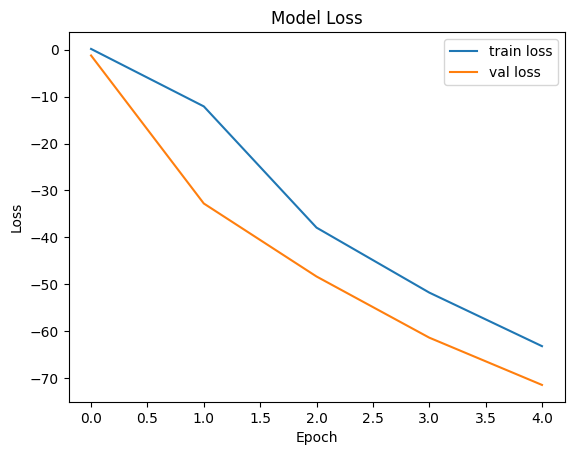

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.2f}')

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
